In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from pmc import MultiCalibrator, Auditor
from KiTE.metrics import ELCE2
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

In [ ]:
!pip install git+https://github.com/A-Good-System-for-Smart-Cities/KiTE-utils.git

In [ ]:
!pip install git+https://github.com/cavalab/pmcboost

  Cloning https://github.com/cavalab/pmcboost to /tmp/pip-req-build-f7di5ftl
  Running command git clone --filter=blob:none --quiet https://github.com/cavalab/pmcboost /tmp/pip-req-build-f7di5ftl
  Resolved https://github.com/cavalab/pmcboost to commit 599b7f9792bc475d2cf803e455b9a5564670f625
  Preparing metadata (setup.py) ... done
  Created wheel for pmcboost: filename=pmcboost-0.2-py3-none-any.whl size=11300 sha256=668b0d49c9c5d73c4ad42bc768858ff2cc2737be1a7da763bd6a841c875596f1
  Stored in directory: /tmp/pip-ephem-wheel-cache-rmg50bz_/wheels/25/41/7c/b5555e09d1079cf56e3d7975cae0bb3a5e664dfe26342b2538
Successfully built pmcboost


# Importing Data

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/afarahi/Scientific-Machine-Learning/main/AHS_2019_Cleaned.CSV').drop('Unnamed: 0', axis=1)
df.head()

,BLACK,HHSEX,METRO,HHGRAD,HHMAR,HHCITSHP,HHAGE,NUMPEOPLE,HINCP,DIVISION,OWNER
0,0.0,1,1.0,44,1,1,52,3,5.409933,5,1.0
1,0.0,2,1.0,44,4,1,80,2,5.303196,1,1.0
2,0.0,1,1.0,47,1,1,72,2,4.825426,7,1.0
3,1.0,2,1.0,40,6,1,60,1,4.544068,4,0.0
4,0.0,2,1.0,39,3,1,80,2,4.309630,4,0.0


In [ ]:
# convert category dtype to numeric
df['OWNER']=df['OWNER'].astype('int64')

In [ ]:
df['OWNER']=df['OWNER'].astype('category')
features = ['BLACK', 'HHSEX', 'METRO', 'HHGRAD', 'HHMAR', 'HHCITSHP', 'HHAGE', 'NUMPEOPLE', 'HINCP', 'DIVISION']
dependent_var = ['OWNER']

X = df[features]
y = df[dependent_var]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25,random_state=1090)
condition_test=X_test.index

# Multicalibration with Random Forest classifier


## Before Multicalibration

In [ ]:
#obtain predicted probabilities for random forest classifier using estimator
estimator = RandomForestClassifier()
estimator.fit(X_train, y_train)
y_pred_probs_rf = estimator.predict_proba(X_test)[:,1]

/var/folders/cm/3djk6lh16jx8s5wnl01pttbw0000gn/T/ipykernel_69544/3773694305.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train)


In [ ]:
result_rf=ELCE2(np.array(df[['HINCP','BLACK']])[condition_test],  np.array(df['OWNER'][condition_test]) ,y_pred_probs_rf, kernel_function="rbf", prob_kernel_width=0.1, iterations=500, use_diffusion_distance=False, verbose=True,random_state=None, n_jobs=1,gamma=25)

INFO:root:test value = 0.0009471596890898169
INFO:root:Computing the null distribution.
INFO:root:p-value < 0.002 	 (resolution : 0.002)


## After Multicalibration

In [ ]:
estimator = RandomForestClassifier()
est = MultiCalibrator(
        estimator = estimator,
        auditor_type = Auditor(groups=['HINCP','BLACK'],metric="MC")
        )

    # train
est.fit(X_train, y_train.squeeze())
p= est.predict_proba(X_test)[:,1]

INFO:pmc.auditor:self.bins_: [0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
INFO:pmc.auditor:group size limit: 182
INFO:pmc.auditor:category size limit: 0


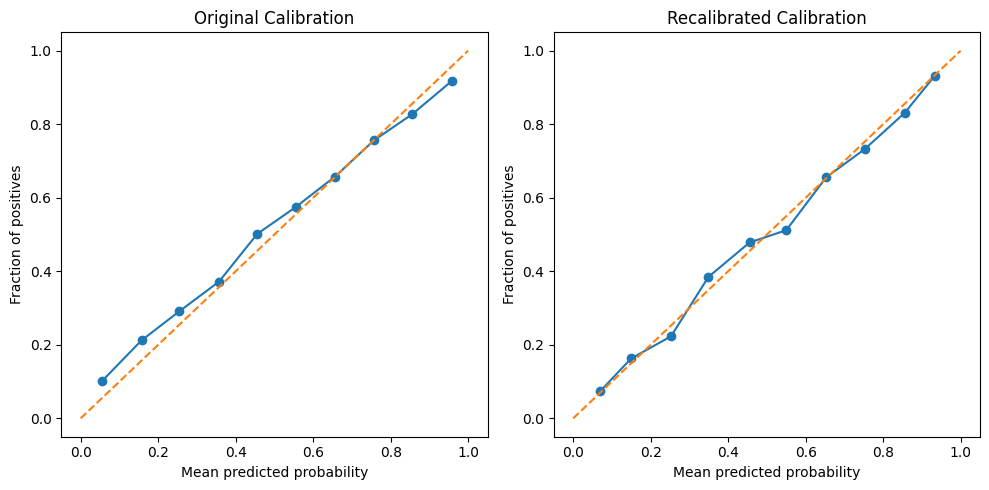

In [ ]:
from sklearn.calibration import calibration_curve

def plot_calibration_curve(y_true, y_prob, n_bins=10):
    prob_true, prob_pred = calibration_curve(y_true, y_prob, n_bins=n_bins)
    plt.plot(prob_pred, prob_true, marker='o')
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.xlabel('Mean predicted probability')
    plt.ylabel('Fraction of positives')
    plt.title('Calibration curve')

# Plot calibration curves
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plot_calibration_curve(y_test, y_pred_probs_rf)
plt.title('Original Calibration')

plt.subplot(1, 2, 2)
plot_calibration_curve(y_test, p)
plt.title('Recalibrated Calibration')

plt.tight_layout()
plt.show()

In [ ]:
result_rf_mc=ELCE2(np.array(df[['HINCP','BLACK']])[condition_test],  np.array(df['OWNER'][condition_test]) ,p, kernel_function="rbf", prob_kernel_width=0.2, iterations=500, use_diffusion_distance=False, verbose=True,random_state=None, n_jobs=1,gamma=25)

INFO:root:test value = 0.0002449920507892157
INFO:root:Computing the null distribution.
INFO:root:p-value < 0.002 	 (resolution : 0.002)


## After PMC

In [ ]:
estimator = RandomForestClassifier()
est = MultiCalibrator(estimator = estimator, auditor_type = Auditor(groups=['HINCP','BLACK'],metric="PMC"))

# train
est.fit(X_train, y_train.squeeze())
p= est.predict_proba(X_test)[:,1]

In [ ]:
result_rf_pmc=ELCE2(np.array(df[['HINCP','BLACK']])[condition_test],  np.array(df['OWNER'][condition_test]) ,p, kernel_function="rbf", prob_kernel_width=0.2, iterations=500, use_diffusion_distance=False, verbose=True,random_state=None, n_jobs=1,gamma=25)

INFO:root:test value = 0.0001924607070262316
INFO:root:Computing the null distribution.
INFO:root:p-value ~= 0.008 	 (resolution : 0.002)


# Multicalibration with Logistic Regression


## Before Multicalibration

In [ ]:
estimator = LogisticRegression()
estimator.fit(X_train, y_train)
y_pred_probs_lr = estimator.predict_proba(X_test)[:,1]

/Users/ritwikvashistha/anaconda3/envs/fernando/lib/python3.10/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/ritwikvashistha/anaconda3/envs/fernando/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
result_lr=ELCE2(np.array(df[['HINCP','BLACK']])[condition_test],  np.array(df['OWNER'][condition_test]) ,y_pred_probs_lr, kernel_function="rbf", prob_kernel_width=0.1, iterations=500, use_diffusion_distance=False, verbose=True,random_state=None, n_jobs=1)

INFO:root:test value = 0.0003035953989023645
INFO:root:Computing the null distribution.
INFO:root:p-value < 0.002 	 (resolution : 0.002)


## Post Multicalibration

In [ ]:
estimator = LogisticRegression()
est = MultiCalibrator(
      estimator = estimator,
      auditor_type = Auditor(groups=['HINCP','BLACK'],metric="MC")
      )

  # train
est.fit(X_train,y_train.squeeze())
est.predict_proba(X_test)
p= est.predict_proba(X_test)[:,1]

In [ ]:
result_lr_mc=ELCE2(np.array(X_test[['HINCP','BLACK']]),  np.array(df['OWNER'][condition_test]) ,p, kernel_function="rbf", prob_kernel_width=0.1, iterations=500, use_diffusion_distance=False, verbose=True,random_state=None, n_jobs=1,gamma=25)

INFO:root:test value = 0.0013788949340563649
INFO:root:Computing the null distribution.
INFO:root:p-value < 0.002 	 (resolution : 0.002)


## After PMC

In [ ]:
estimator = LogisticRegression()
est = MultiCalibrator(estimator = estimator, auditor_type = Auditor(groups=['HINCP','BLACK'],metric="PMC"))

# train
est.fit(X_train, y_train.squeeze())
p= est.predict_proba(X_test)[:,1]

In [ ]:
result_lr_pmc=ELCE2(np.array(df[['HINCP','BLACK']])[condition_test],  np.array(df['OWNER'][condition_test]) ,p, kernel_function="rbf", prob_kernel_width=0.2, iterations=500, use_diffusion_distance=False, verbose=True,random_state=None, n_jobs=1,gamma=25)

INFO:root:test value = 0.0012959109323378481
INFO:root:Computing the null distribution.
INFO:root:p-value < 0.002 	 (resolution : 0.002)


# Multicalibration with Constant classifier

## Before Multicalibration

In [ ]:
from sklearn.dummy import DummyClassifier
estimator = DummyClassifier(strategy='prior')
estimator.fit(X_train, y_train)
y_pred_probs_dc = estimator.predict_proba(X_test)[:,1]

In [ ]:
condition_test=X_test.index
result_constant=ELCE2(np.array(df[['HINCP','BLACK']])[condition_test],  np.array(df['OWNER'][condition_test]) ,y_pred_probs_dc, kernel_function="rbf", prob_kernel_width=0.1, iterations=500, use_diffusion_distance=False, verbose=True,random_state=None, n_jobs=1)

INFO:root:test value = 0.0028152461208286444
INFO:root:Computing the null distribution.
INFO:root:p-value < 0.002 	 (resolution : 0.002)


## After Multicalibration

In [ ]:
estimator = DummyClassifier(strategy='prior')

est = MultiCalibrator(
      estimator = estimator,
      auditor_type = Auditor(groups=['HINCP','BLACK'],metric="MC")
      )

# train
est.fit(X_train,y_train.squeeze())
p=est.predict_proba(X_test)[:,1]

In [ ]:
result_constant_mc=ELCE2(np.array(df[['HINCP','BLACK']])[condition_test],  np.array(df['OWNER'][condition_test]) ,p, kernel_function="rbf", prob_kernel_width=0.7, iterations=500, use_diffusion_distance=False, verbose=True,random_state=None, n_jobs=1)

INFO:root:test value = 0.0016783577373652096
INFO:root:Computing the null distribution.
INFO:root:p-value < 0.002 	 (resolution : 0.002)


## After PMC

In [ ]:
estimator = DummyClassifier(strategy='prior')
est = MultiCalibrator(estimator = estimator, auditor_type = Auditor(groups=['HINCP','BLACK'],metric="PMC"))

# train
est.fit(X_train, y_train.squeeze())
p= est.predict_proba(X_test)[:,1]

In [ ]:
result_constant_pmc=ELCE2(np.array(df[['HINCP','BLACK']])[condition_test],  np.array(df['OWNER'][condition_test]) ,p, kernel_function="rbf", prob_kernel_width=0.2, iterations=500, use_diffusion_distance=False, verbose=True,random_state=None, n_jobs=1,gamma=25)

INFO:root:test value = 0.008403606374076063
INFO:root:Computing the null distribution.
INFO:root:p-value < 0.002 	 (resolution : 0.002)


In [ ]:
rf_model = RandomForestClassifier(random_state=1090)
rf_model.fit(X_train, y_train.values.ravel())

RandomForestClassifier(random_state=1090)